# EXERCISE 3 - POS TAGGING TASK WITH STACKED CNN CLASSIFIER

Lets download our data from [source](https://github.com/UniversalDependencies/UD_English-EWT.git)

In [1]:
# Clone the repository
# !git clone --depth 2 --single-branch --branch dev https://github.com/UniversalDependencies/UD_English-EWT.git

fatal: destination path 'UD_English-EWT' already exists and is not an empty directory.


In [1]:
# !pip install conllu  # You can install conllu for the read of the files
import conllu
import pandas as pd
import numpy as np

def read_conllu_file(file_path):
    """
    Read a conllu file and read each sentences separated
    :param file_path: String
    :return: data in sentences specifically: <class 'conllu.models.SentenceList'>
    """
    # Read the CoNLL-U file
    with open(file_path, "r", encoding="utf-8") as f:
        # Parse the CoNLL-U formatted data
        data = f.read()
        sentences = conllu.parse(data)
    return sentences


# Function to extract tokens and UPOS tags from
# SentenceList object and create a DataFrame
def create_pos_df(sentences):
    """
    Read the conllu sentences list and import them in a dataframe
    including the information we need
    :param sentences: conllu.models.SentenceList
    :return: pd.DataFrame object
    """
    id_list = []
    tokens_list = []
    upos_tags_list = []

    for sentence in sentences:
        for token in sentence:  # Extract token and UPOS tag
            id = token['id']
            token_text = token['form']
            upos_tag = token['upos']

            id_list.append(id)
            tokens_list.append(token_text)
            upos_tags_list.append(upos_tag)


    # Create dataframe
    dataframe = pd.DataFrame({'id': id_list, "token": tokens_list, "UPOS": upos_tags_list})
    return dataframe

# Initialize the file paths
for split in ('train', 'dev', 'test'):
    file_path = f'C:/1. Python/MLP_Classifier/UD_English-EWT/en_ewt-ud-{split}.conllu'
    print(file_path)
    sentences = read_conllu_file(file_path)

    # Create DataFrame for the current split
    pos_df = create_pos_df(sentences)
    # Assign DataFrame to variable with specific name
    globals()[f"{split}_pos"] = pos_df

C:/1. Python/MLP_Classifier/UD_English-EWT/en_ewt-ud-train.conllu
C:/1. Python/MLP_Classifier/UD_English-EWT/en_ewt-ud-dev.conllu
C:/1. Python/MLP_Classifier/UD_English-EWT/en_ewt-ud-test.conllu


In [2]:
print(f"train_pos dataframe: {len(train_pos)}")
print(f"test_pos dataframe: {len(test_pos)}")
print(f"dev_pos dataframe: {len(dev_pos)}")

# !rm -rf /content/UD_English-EWT # free up memory

train_pos dataframe: 207229
test_pos dataframe: 25450
dev_pos dataframe: 25511


### CLEAN OUR DATA

In [3]:
# Check the labels of our data
train_pos.UPOS.unique()

array(['PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'AUX',
       'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', '_', 'INTJ', 'X',
       'SYM'], dtype=object)

In [4]:
# Drop rows that contain UPOS = '_'
train_pos = train_pos[train_pos.UPOS != '_']
test_pos = test_pos[test_pos.UPOS != '_']
dev_pos = dev_pos[dev_pos.UPOS != '_']

In [5]:
print("Number of tags: ",len(train_pos.UPOS.unique()))

Number of tags:  17


In [6]:
print(f'The length of the training set before the preprocess: {len(train_pos)}')

# Remove duplicate words where their id is not integer but tuple
train_pos = train_pos[train_pos.id.apply(lambda x: isinstance(x, int))]
dev_pos = dev_pos[dev_pos.id.apply(lambda x: isinstance(x, int))]
test_pos = test_pos[test_pos.id.apply(lambda x: isinstance(x, int))]

# Reset the index of our dataframes because we dropped some rows
train_pos = train_pos.reset_index()
dev_pos = dev_pos.reset_index()
test_pos = test_pos.reset_index()

print(f'After the preprocess: {len(train_pos)}')

The length of the training set before the preprocess: 204615
After the preprocess: 204578


In [7]:
train_pos.head(5)

,index,id,token,UPOS
0,0,1,Al,PROPN
1,1,2,-,PUNCT
2,2,3,Zaman,PROPN
3,3,4,:,PUNCT
4,4,5,American,ADJ


In [8]:
test_pos.UPOS.value_counts()

UPOS
NOUN     4137
PUNCT    3096
VERB     2605
PRON     2161
PROPN    2077
ADP      2033
DET      1897
ADJ      1787
AUX      1543
ADV      1178
CCONJ     737
PART      649
NUM       542
SCONJ     384
INTJ      120
SYM       109
X          39
Name: count, dtype: int64

### BUILD OUR DATASET IN SENTENCES

In [9]:
from tqdm import tqdm


def make_sentences(dataframe):
    """
    Make sentences from the train, development and test set in order
    to create windows for each word
    :param dataframe: pandas df
    :return: array of sentences
    :return: array of position of each word
    :return: array of tags for each word
    """
    all_sents = []
    all_positions = []
    all_tags = []
    sentence = []
    position = []
    pos_tags = []
    cnt = 0
    with tqdm(total = len(dataframe)) as pbar:
        for index, row in dataframe.iterrows():
            id = row['id']
            token= row['token']
            upos = row['UPOS']
            if id > cnt:
                cnt = id
                sentence.append(token)
                position.append(index)
                pos_tags.append(upos)
            else:
                all_sents.append(sentence)
                all_positions.append(position)
                all_tags.append(pos_tags)
                sentence = []
                sentence.append(token)
                position= []
                position.append(index)
                pos_tags = []
                pos_tags.append(upos)
                cnt=id
            pbar.update(1)  # Update the progress bar
        all_sents.append(sentence)
        all_positions.append(position)
        all_tags.append(pos_tags)

    return all_sents, all_positions, all_tags

X_train, all_train_positions, y_train = make_sentences(train_pos)
print(f'\nThe total sentences of the training set is: {len(X_train)}')
X_dev, all_dev_positions, y_dev = make_sentences(dev_pos)
print(f'\nThe total sentences of the development set is: {len(X_dev)}')
X_test, all_test_positions, y_test = make_sentences(test_pos)
print(f'\nThe total sentences of the test set is: {len(X_test)}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204578/204578 [00:08<00:00, 24618.71it/s]



The total sentences of the training set is: 12544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25149/25149 [00:01<00:00, 24933.76it/s]



The total sentences of the development set is: 2001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25094/25094 [00:01<00:00, 24586.16it/s]


The total sentences of the test set is: 2077


In [10]:
print("Size of train: ",len(X_train))
print("Size of dev: ",len(X_dev))
print("Size of test: ",len(X_test))

Size of train:  12544
Size of dev:  2001
Size of test:  2077


### PREPARE OUR DATASET

We are going to use keras vectorizer in order to build fixed length dataset for each sentence.

In [11]:
# Join the words into sentences in order to be added in the vectorizer
X_train_final = [' '.join(tokens) for tokens in X_train]
X_dev_final = [' '.join(tokens) for tokens in X_dev]
X_test_final = [' '.join(tokens) for tokens in X_test]

In [19]:
%%capture
!pip install -U transformers

In [12]:
# Check the version of our package *transformer*
import transformers
transformers.__version__

'4.38.2'

In [13]:
# %%capture
# !pip install torchtext
# !pip install spacy
# !python -m spacy download en_core_web_sm
#  !pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu118
# !pip install torchmetrics torchtext --index-url https://download.pytorch.org/whl/cu118

import torch
import spacy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from collections import Counter


MAX_SEQUENCE_LENGTH = 96


# Join the y targets into sentences
y_train_final = [' '.join(tokens) for tokens in y_train]
y_dev_final = [' '.join(tokens) for tokens in y_dev]
y_test_final = [' '.join(tokens) for tokens in y_test]


# Tokenize text
tokenizer = get_tokenizer("spacy")
y_train_tokenized = [tokenizer(text) for text in y_train_final]
y_dev_tokenized = [tokenizer(text) for text in y_dev_final]
y_test_tokenized = [tokenizer(text) for text in y_test_final]

# Build vocabulary
counter = Counter()
for tokens in y_train_tokenized:
    counter.update(tokens)
vocab = build_vocab_from_iterator([counter], specials=['<pad>'])  # Add padding token to vocabulary
vocab.set_default_index(vocab['<pad>'])  # Set default index for padding

# Encode text sequences
y_train_encoded = [torch.tensor([vocab[token] for token in tokens], dtype=torch.long) for tokens in y_train_tokenized]
y_dev_encoded = [torch.tensor([vocab[token] for token in tokens], dtype=torch.long) for tokens in y_dev_tokenized]
y_test_encoded = [torch.tensor([vocab[token] for token in tokens], dtype=torch.long) for tokens in y_test_tokenized]

# Pad sequences
y_train_padded = pad_sequence([torch.cat((seq[:MAX_SEQUENCE_LENGTH], torch.zeros(MAX_SEQUENCE_LENGTH - len(seq), dtype=torch.long))) if len(seq) < MAX_SEQUENCE_LENGTH else seq[:MAX_SEQUENCE_LENGTH] for seq in y_train_encoded], batch_first=True)
y_dev_padded = pad_sequence([torch.cat((seq[:MAX_SEQUENCE_LENGTH], torch.zeros(MAX_SEQUENCE_LENGTH - len(seq), dtype=torch.long))) if len(seq) < MAX_SEQUENCE_LENGTH else seq[:MAX_SEQUENCE_LENGTH] for seq in y_dev_encoded], batch_first=True)
y_test_padded = pad_sequence([torch.cat((seq[:MAX_SEQUENCE_LENGTH], torch.zeros(MAX_SEQUENCE_LENGTH - len(seq), dtype=torch.long))) if len(seq) < MAX_SEQUENCE_LENGTH else seq[:MAX_SEQUENCE_LENGTH] for seq in y_test_encoded], batch_first=True)

C:\1. Python\Transformer_Classifier\venv\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [14]:
print(y_train[1])
print(y_train_encoded[1])
print(y_train_padded[1])

['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'AUX', 'AUX', 'VERB', 'PRON', 'NOUN', 'ADP', 'NOUN', 'PART', 'VERB', 'PUNCT', 'PUNCT']
tensor([ 2,  6,  1,  5,  6,  7,  1,  8,  8,  3,  4,  1,  5,  1, 12,  3,  2,  2])
tensor([ 2,  6,  1,  5,  6,  7,  1,  8,  8,  3,  4,  1,  5,  1, 12,  3,  2,  2,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])


In [15]:
# Check the unique values
np.unique(y_train_padded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int64)

### Tokenize the dataset via pretrained Transformer model

In [16]:
from transformers import BertTokenizer

# Instantiate the BERT tokenizer with WordPiece tokenization
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_basic_tokenize=False)

# Function for the tokenization
def tokenize_text(data, tokenizer, max_length=MAX_SEQUENCE_LENGTH):
    return tokenizer(data, padding='max_length',
                     max_length=max_length, truncation=True, return_tensors='pt')

bert_train = tokenize_text(X_train_final, bert_tokenizer)
bert_val = tokenize_text(X_dev_final, bert_tokenizer)
bert_test = tokenize_text(X_test_final, bert_tokenizer)


bert_train

{'input_ids': tensor([[ 101,  100, 1011,  ...,    0,    0,    0],
        [ 101, 1031,  100,  ...,    0,    0,    0],
        [ 101,  100, 1024,  ...,    0,    0,    0],
        ...,
        [ 101,  100, 2027,  ...,    0,    0,    0],
        [ 101,  100, 5126,  ...,    0,    0,    0],
        [ 101,  100, 2097,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [17]:
import torch
from transformers import BertForTokenClassification, BertTokenizer, BertConfig

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
bert_model = BertForTokenClassification.from_pretrained(model_name, num_labels=18)
# Print the model architecture
# print(bert_model)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### RUN THE MODEL IN GPU

In [18]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Running on GPU.")

# Put the model on GPU
bert_model = bert_model.to(device)  # Move the model to the specified device
print(torch.__version__)

CUDA is available. Running on GPU.
2.2.0+cu118


### PREPARE OUR DATASET VIA PYTORCH

In [19]:
%%capture
#!pip install torchmetrics
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, TensorDataset

In [21]:
# Define batch size
batch_size = 16

# Create TensorDatasets
train_dataset = TensorDataset(bert_train['input_ids'], bert_train['attention_mask'], y_train_padded)
val_dataset = TensorDataset(bert_val['input_ids'], bert_val['attention_mask'], y_dev_padded)
test_dataset = TensorDataset(bert_test['input_ids'], bert_test['attention_mask'], y_test_padded)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### FREEZE THE BERT PARAMETERS AND UNFREEZE THE CLASSIFICATION HEAD

In [23]:
# Unfreeze the classification head and 3 last layers of BERT
trainable_parameters = ['classifier']
for name, param in bert_model.named_parameters():
    param.requires_grad = any(name.startswith(prefix) for prefix in trainable_parameters)

# Print the names of trainable parameters
for name, param in bert_model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.weight
classifier.bias


In [24]:
# Freeze BERT model parameters
for param in bert_model.parameters():
    param.requires_grad = True

# Unfreeze the parameters of the classification head
for param in bert_model.classifier.parameters():
    param.requires_grad = True

# Print the names of trainable parameters
for name, param in bert_model.named_parameters():
    if param.requires_grad:
        print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters
print("Number of trainable parameters:", count_parameters(bert_model))

Number of trainable parameters: 108905490


In [26]:
def accuracy_metric(preds, labels):
    # Create a mask to filter out padding tokens (assuming padding token is 0)
    mask = (labels != 0)
    
    # Count total non-padding tokens
    total_tokens = mask.sum()
    
    # Compare only non-padding tokens for accuracy
    correct = (preds[mask] == labels[mask]).sum().float()
    
    # Calculate accuracy
    accuracy = correct / total_tokens
    return accuracy

In [27]:
# Define the number of epochs
num_epochs = 15

# Prepare optimizer and loss function
optimizer = Adam(bert_model.parameters(), lr=5e-5)
loss_function = CrossEntropyLoss()
# accuracy_metric = Accuracy(task="multiclass", num_classes=18).to(device)


# Initialize lists to store history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Initialize variables to track best validation loss and corresponding model weights
best_val_loss = float('inf')
best_model_weights = None

# Training loop
for epoch in range(num_epochs):
    # Training
    bert_model.train()
    total_loss = 0
    total_accuracy = 0
    cnt=0
    for batch in train_loader:
        cnt+=1
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move the tensors to the specified device
        optimizer.zero_grad()
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += accuracy_metric(outputs.logits.argmax(dim=-1), labels)
        print(f'For batch "{cnt}": Training - Loss: {total_loss/cnt:.3f}, Accuracy: {total_accuracy/cnt:.3f}', end='\r')

    
    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = total_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Training - Loss: {avg_train_loss:.3f}, Accuracy: {avg_train_accuracy:.3f}')

    # Validation
    bert_model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move the tensors to the specified device
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
        val_loss = outputs.loss
        total_val_loss += val_loss.item()
        total_val_accuracy += accuracy_metric(outputs.logits.argmax(dim=-1), labels)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    
    # Check if the current validation loss is better than the best one so far
    if avg_val_loss < best_val_loss:
        # Update best validation loss and store model weights
        print(f'val_loss improved from {best_val_loss:.6f} to {avg_val_loss:.6f}, saving model to /content/checkpoints/best_model.pth')
        best_val_loss = avg_val_loss
        best_model_weights = bert_model.state_dict()
        torch.save(best_model_weights, '/content/checkpoints/best_model.pth')  # Save the model checkpoint
    else:
        print(f'val_loss did not improved from {best_val_loss:.6f}')
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    print(f'Validation - Loss: {avg_val_loss:.3f}, Accuracy: {avg_val_accuracy:.3f}')

Epoch 1/15:784": Training - Loss: 0.188, Accuracy: 0.684
Training - Loss: 0.188, Accuracy: 0.684
val_loss improved from inf to 0.071422, saving model to /content/checkpoints/best_model.pth
Validation - Loss: 0.071, Accuracy: 0.836
Epoch 2/15:784": Training - Loss: 0.077, Accuracy: 0.856
Training - Loss: 0.077, Accuracy: 0.856
val_loss improved from 0.071422 to 0.052031, saving model to /content/checkpoints/best_model.pth
Validation - Loss: 0.052, Accuracy: 0.876
Epoch 3/15:784": Training - Loss: 0.058, Accuracy: 0.890
Training - Loss: 0.058, Accuracy: 0.890
val_loss did not improved from 0.052031
Validation - Loss: 0.054, Accuracy: 0.877


KeyboardInterrupt: 

In [29]:
# Load the best model parameters
best_model_weights = torch.load('/content/checkpoints/best_model.pth')
# Load the best model weights
bert_model.load_state_dict(best_model_weights)

<All keys matched successfully>

## TRAINING CURVES FOR OUR TRANSFORMER

In [151]:
%%capture
!pip install matplotlib

import matplotlib.pyplot as plt

def plot_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Plot the history of epochs for loss and accuracy
    :param train_losses: List of training losses for each epoch
    :param train_accuracies: List of training accuracies for each epoch
    :param val_losses: List of validation losses for each epoch
    :param val_accuracies: List of validation accuracies for each epoch
    :return: None
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation losses
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


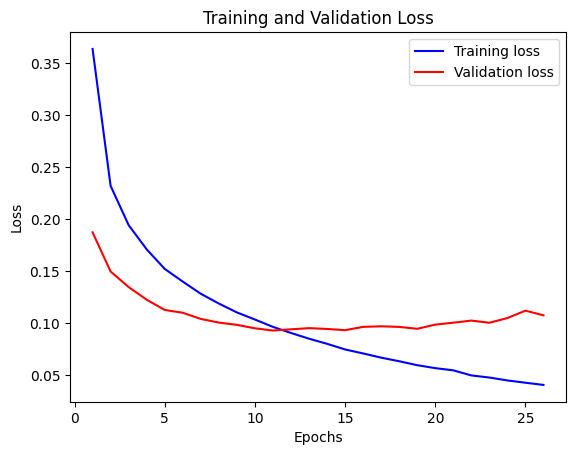

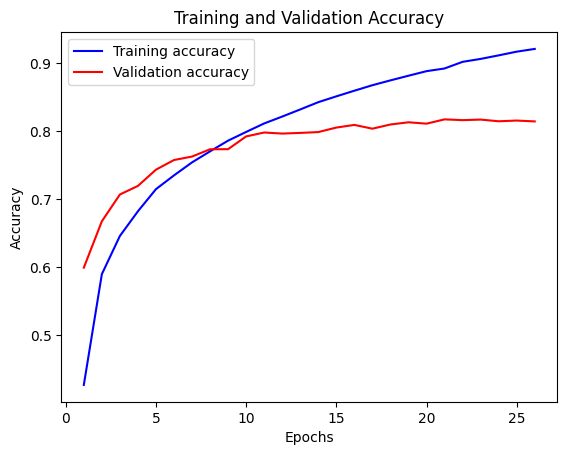

In [152]:
train_losses = np.array(train_losses).flatten()
train_accuracies = np.array([acc.item() for acc in train_accuracies])
val_losses = np.array(val_losses).flatten()
val_accuracies = np.array([acc.item() for acc in val_accuracies])

plot_history(train_losses, train_accuracies, val_losses, val_accuracies)

### PREDICT ON THE TEST SET

In [30]:
# Test
bert_model.eval()
total_test_accuracy = 0
for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move the tensors to the specified device
    with torch.no_grad():
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    total_test_accuracy += accuracy_metric(outputs.logits.argmax(dim=-1), labels)
avg_test_accuracy = total_test_accuracy / len(test_loader)
print(f'Test Accuracy: {avg_test_accuracy}')

Test Accuracy: 0.8655315041542053


### DISPLAY THE CLASSIFICATION REPORT

In [31]:
%%capture
# !pip install skikit-learn
from sklearn.metrics import classification_report

# Evaluation on test data
bert_model.eval()
predictions_test = []
true_labels_test = []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

    # Filter out predictions and labels for padding tokens (assuming padding token is 0)
    predictions_test.extend(outputs.logits.argmax(dim=-1).cpu().tolist())
    true_labels_test.extend(labels.cpu().tolist())

# # Convert labels and predictions to numpy arrays
true_labels_test = np.array(true_labels_test)
predictions_test = np.array(predictions_test)

In [33]:
# In order to load the model from the weights file, we need the architecture
class_labels = train_pos.UPOS.unique()

print(class_labels)

['PROPN' 'PUNCT' 'ADJ' 'NOUN' 'VERB' 'DET' 'ADP' 'AUX' 'PRON' 'PART'
 'SCONJ' 'NUM' 'ADV' 'CCONJ' 'INTJ' 'X' 'SYM']


In [36]:
from sklearn.metrics import classification_report, precision_recall_curve, auc

def classification_reports(predictions_train, y_train, class_names):
    """
    Create a function for the classification report for the baseline model for all labels
    :param predictions_train: np.array
    :param predictions_dev: np.array
    :param predictions_test: np.array
    :param y_train: np.array
    :param y_dev: np.array
    :param y_test: np.array
    :param class_names: array of strings
    :return: null
    """

    y_true_train = []
    y_preds_train = []
    for i in range(len(y_train)):
      if y_train[i]>0 and predictions_train[i]>0:
        y_true_train.append(y_train[i])
        y_preds_train.append(predictions_train[i])
          
    classification_report_train = classification_report(y_true_train, y_preds_train, target_names=class_names,zero_division=0)

    combined_cl_report = f'\n\t\tClassification report on Test Set: \n\n{classification_report_train}'
    # combined_cl_report += f'\n\t\tClassification report on Development Set: \n\n{classification_report_dev}'
    # combined_cl_report += f'\n\t\tClassification report on Testing Set: \n\n{classification_report_test}'

    print(combined_cl_report)

In [37]:
print(predictions_test[1])
print(true_labels_test[1])

14
14


In [38]:
predictions_test = predictions_test.flatten()
true_labels_test = true_labels_test.flatten()

# print(classification_report(predictions_test, true_labels_test,zero_division=0))
classification_reports(predictions_test, true_labels_test, class_labels)


		Classification report on Test Set: 

              precision    recall  f1-score   support

       PROPN       0.84      0.84      0.84      4114
       PUNCT       0.92      0.96      0.94      3041
         ADJ       0.91      0.89      0.90      2602
        NOUN       0.89      0.91      0.90      2158
        VERB       0.91      0.89      0.90      2032
         DET       0.86      0.92      0.89      1894
         ADP       0.83      0.78      0.80      1786
         AUX       0.93      0.94      0.94      1543
        PRON       0.68      0.76      0.72      2073
        PART       0.86      0.77      0.81      1178
       SCONJ       0.91      0.85      0.88       734
         NUM       0.95      0.90      0.92       649
         ADV       0.86      0.78      0.82       538
       CCONJ       0.89      0.81      0.85       384
        INTJ       0.96      0.42      0.58       107
           X       0.61      0.52      0.56       120
         SYM       0.00      0.00      0.